<a href="https://colab.research.google.com/github/X-pose/Skin-Disease-Classifiaction-Models---Deep-Learning-Assignment/blob/IT21223594---Thalangama-T.P/VGG16_Skin_disease_classification_model_IT21223594.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**VGG16-Skin disease classification model**


---

Author : Thalangama T.P.

IT Number : IT21223594

#Dataset mounting and data extraction


---



In [1]:

#extract dataset----------------------------------------------------------------------------------------
import zipfile
import os
from google.colab import drive
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Mount Google Drive
drive.mount('/content/drive')

# Path to dataset zip file in Google Drive
zip_file_path = '/content/drive/My Drive/Skin Disease.v1i.multiclass.zip'

# Directory to extract the files
extract_dir = '/content/Extracted_data'

# Create directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Dataset extracted to {extract_dir}")

Mounted at /content/drive
Dataset extracted to /content/Extracted_data


#Data splitting


---


#### The original dataset contained only training and test sets. For validation purposes, I have allocated 10% of the training data to create a separate validation set. The following code implements the logic for splitting the data and creating the validation set.

In [2]:
import pandas as pd
import shutil
import random
from pathlib import Path

# Set up paths for train, test, and validation data
data_dir = Path('/content/Extracted_data')
train_images_dir = data_dir / 'train'
test_images_dir = data_dir / 'test'
val_images_dir = data_dir / 'valid'

# Validating the validation directory existence
val_images_dir.mkdir(parents=True, exist_ok=True)

# Load the CSV file with annotations
train_annotations_path = train_images_dir / '_classes.csv'
train_df = pd.read_csv(train_annotations_path)

# Load test data CSV
test_annotations_path = test_images_dir / '_classes.csv'
test_df = pd.read_csv(test_annotations_path)

# Split 10% of the training data into validation
train_filenames = train_df['filename'].tolist()
random.shuffle(train_filenames)
split_index = int(0.9 * len(train_filenames))
train_split = train_filenames[:split_index]
val_split = train_filenames[split_index:]

# Create a new DataFrame for validation data
val_df = train_df[train_df['filename'].isin(val_split)]
train_df = train_df[train_df['filename'].isin(train_split)]

# Move validation images to the validation folder
for val_filename in val_split:
    val_img_path = train_images_dir / val_filename
    shutil.move(str(val_img_path), val_images_dir / val_filename)

# Save the updated train and validation CSV files
train_df.to_csv(train_images_dir / '_classes.csv', index=False)
val_df.to_csv(val_images_dir / '_classes.csv', index=False)

# Optionally print the number of images in each set
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


Training set size: 3674
Validation set size: 409
Test set size: 454


#Dataloader setup


---

#### The following codebase contains the logic related to applying transforms and data augmentation to the split datasets. Train data uses more data augmentation techniques (for better generalization of the model) while validation and test datasets use the basic transforms to mimic real-world scenarios. Then data are loaded into respective DataLoaders to be used in the later parts of the training.

In [3]:
import os
import pandas as pd
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image


class SkinDiseaseDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.classes = list(self.data_frame.columns[1:])  # Skip 'filename' column


    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        labels = torch.tensor(self.data_frame.iloc[idx, 1:].values.astype('int'), dtype=torch.float32)


        if self.transform:
            image = self.transform(image)

        return image, labels

# Defining Transformations
# More data augmentation added to help with better generalization
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 as per VGG16 default input size
    transforms.RandomHorizontalFlip(),  # Default augmentation: horizontal flip
    transforms.ColorJitter(brightness=0.2, saturation=0.2),  # Data Augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Default normalization for VGG16
])

#Contains only the basic transform to mimic real world data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Paths to CSVs and Image Directories
train_csv = '/content/Extracted_data/train/_classes.csv'
train_img_dir = '/content/Extracted_data/train/'

valid_csv = '/content/Extracted_data/valid/_classes.csv'
valid_img_dir = '/content/Extracted_data/valid/'



# Create Datasets
train_dataset = SkinDiseaseDataset(csv_file=train_csv, img_dir=train_img_dir, transform=train_transforms)
valid_dataset = SkinDiseaseDataset(csv_file=valid_csv, img_dir=valid_img_dir, transform=test_transforms)


# Create DataLoaders. In here I am using smaller batch sizes for faster convergence
train_loader = DataLoader(train_dataset, batch_size= 8, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=8)



# Checking DataLoader Output
for images, labels in train_loader:
    print(images.size(), labels.size())
    break


torch.Size([8, 3, 224, 224]) torch.Size([8, 17])


#Model codebase


---
#### The following codebase creates a classification model using a pre-trained VGG16 network. It freezes featuer extracting layers, and modifies the classifier for 17 skin diseases classes.


In [7]:
import torch
import torchvision
from torchvision.models.vgg import vgg16

def create_classification_model(num_classes=17):  # 17 skin diseases
    # Loading the pre-trained VGG16 model without the top classifier layers
    model = vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1)

    # Freeze the featuer extractor convolutional base
    for param in model.features.parameters():
      param.requires_grad = False

    # Modifying classifier layers
    model.classifier = torch.nn.Sequential(
      torch.nn.Flatten(),
      torch.nn.Linear(25088, 1024),  # First hidden layer
      torch.nn.ReLU(),
      torch.nn.Dropout(0.5),

      torch.nn.Linear(1024, 512),    # Second hidden layer
      torch.nn.ReLU(),
      torch.nn.Dropout(0.4),

      torch.nn.Linear(512, 256),     # Third hidden layer
      torch.nn.ReLU(),

      torch.nn.Linear(256, num_classes),  # Final output layer
    )

    return model

if __name__ == '__main__':
    model = create_classification_model(num_classes=17)
    print(model)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#Loss function, optimizer, and scheduler.


---

In here I am trying to address the class imbalance problems that may included in the dataset by assigning higher weights to less frequent classes. Then after normalizing the class weights (So that they sum to 1 to stabalize the training) and passing the modified weights as paramters to the loss function.

I have selected CrossEntropyLoss for multiclass image classification due to its ability to handle multiple classes, provide effective probabilistic output comparisons, penalize incorrect predictions, and ensure stable gradient computation during training.

As my optimizer, I have selected AdamW with a learning rate of 0.00001 due to its ability to combine the benefits of Adam’s adaptive learning rate with weight decay (L2 regularization), which helps prevent overfitting, ensures stable convergence, and maintains better generalization performance, in deep learning models.

For better learning, I have used a learning rate scheduler, ReduceLROnPlateau(), with a patience of 3 to monitor the loss improvement, as it automatically reduces the learning rate when the loss plateaus, helping to fine-tune the model and avoid overshooting or stagnation during training.

In [10]:
# Import necessary libraries for optimization and scheduling
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np

# Set the device to GPU if available, otherwise use CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate the class counts from the training dataset.
class_counts = np.sum(train_dataset.data_frame.iloc[:, 1:].values, axis=0)

# Set a smoothing factor to prevent division by zero or extremely small weights for underrepresented classes.
smoothing_factor = 1.0

# Calculate class weights inversely proportional to the class counts, adding the smoothing factor to each count.
# This helps deal with class imbalance by assigning higher weights to less frequent classes.
class_weights = 1.0 / torch.tensor(class_counts + smoothing_factor, dtype=torch.float)

# Normalize the class weights so that they sum to 1, which stabilizes the training.
class_weights = class_weights / torch.sum(class_weights)
class_weights = class_weights.to(device)

#Using the CrossEntropyLoss with modified weight to address class imbalance problem
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# Using the AdamW (Adam with weight decay), as the optimizer with a learning rate of 0.00001.
optimizer = optim.AdamW(model.parameters(), lr=0.00001)

# Use a learning rate scheduler to reduce the learning rate when the loss stops improving.
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

model = model.to(device)


#Training and validation loop

---

####Training and validation are both performed within the same code block. Validation is carried out after each training epoch to assess the model's performance on the validation set, tracking both training and validation accuracy, as well as monitoring training and validation loss throughout the process. A graph that show the loss over epoch is displayed at the end of the process.


Epoch 1/15


100%|██████████| 52/52 [00:00<00:00, 61.42it/s]


Train Loss: 0.3007, Train Acc: 0.1824
Valid Loss: 0.2429, Valid Acc: 0.3081
Epoch 2/15


100%|██████████| 52/52 [00:00<00:00, 64.00it/s]


Train Loss: 0.2080, Train Acc: 0.3704
Valid Loss: 0.1589, Valid Acc: 0.5721
Epoch 3/15


100%|██████████| 52/52 [00:00<00:00, 62.22it/s]


Train Loss: 0.1623, Train Acc: 0.4652
Valid Loss: 0.1347, Valid Acc: 0.7213
Epoch 4/15


100%|██████████| 52/52 [00:00<00:00, 63.12it/s]


Train Loss: 0.1423, Train Acc: 0.5128
Valid Loss: 0.1219, Valid Acc: 0.7457
Epoch 5/15


100%|██████████| 52/52 [00:00<00:00, 64.50it/s]


Train Loss: 0.1288, Train Acc: 0.5621
Valid Loss: 0.1133, Valid Acc: 0.6161
Epoch 6/15


100%|██████████| 52/52 [00:00<00:00, 61.48it/s]


Train Loss: 0.1201, Train Acc: 0.5920
Valid Loss: 0.1062, Valid Acc: 0.7653
Epoch 7/15


100%|██████████| 52/52 [00:00<00:00, 62.30it/s]


Train Loss: 0.1125, Train Acc: 0.6037
Valid Loss: 0.1021, Valid Acc: 0.8778
Epoch 8/15


100%|██████████| 52/52 [00:00<00:00, 60.82it/s]


Train Loss: 0.1070, Train Acc: 0.6271
Valid Loss: 0.0982, Valid Acc: 0.8289
Epoch 9/15


100%|██████████| 52/52 [00:00<00:00, 63.46it/s]


Train Loss: 0.1019, Train Acc: 0.6467
Valid Loss: 0.0953, Valid Acc: 0.8166
Epoch 10/15


100%|██████████| 52/52 [00:00<00:00, 63.44it/s]


Train Loss: 0.0988, Train Acc: 0.6432
Valid Loss: 0.0936, Valid Acc: 0.7873
Epoch 11/15


100%|██████████| 52/52 [00:00<00:00, 61.21it/s]


Train Loss: 0.0963, Train Acc: 0.6508
Valid Loss: 0.0921, Valid Acc: 0.7286
Epoch 12/15


100%|██████████| 52/52 [00:00<00:00, 63.04it/s]


Train Loss: 0.0940, Train Acc: 0.6611
Valid Loss: 0.0910, Valid Acc: 0.7579
Epoch 13/15


100%|██████████| 52/52 [00:00<00:00, 62.49it/s]


Train Loss: 0.0925, Train Acc: 0.6598
Valid Loss: 0.0899, Valid Acc: 0.7433
Epoch 14/15


100%|██████████| 52/52 [00:00<00:00, 58.99it/s]


Train Loss: 0.0907, Train Acc: 0.6562
Valid Loss: 0.0894, Valid Acc: 0.7824
Epoch 15/15


100%|██████████| 52/52 [00:00<00:00, 63.74it/s]


Train Loss: 0.0902, Train Acc: 0.6758
Valid Loss: 0.0890, Valid Acc: 0.7286


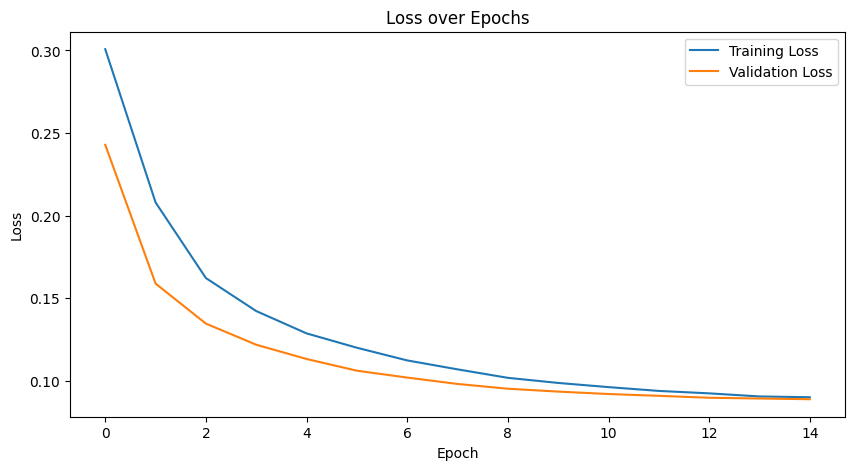

In [11]:
# Updated Training and validation loop for classification task
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm


# Training loop parameters
num_epochs = 15
train_loss_history = []
valid_loss_history = []

class_names = ['Actinic', 'Atopic', 'Benign', 'Candidiasis', 'Dermatitis', 'Dermatofibroma', 'Melanocytic', 'Melanoma', 'Ringworm', 'Squamous', 'Tinea', 'Vascular', 'Carcinoma', 'Cell', 'Keratosis', 'Lesion', 'Nevus']

# Function for training one epoch
def train_one_epoch(model, train_loader, optimizer, criterion, device, class_names):
    model.train()  # Setting the model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item() * images.size(0)  # Total loss for the batch

        # Accuracy calculation
        _, predicted = torch.max(outputs, 1)
        labels_single = torch.argmax(labels, dim=1)  # Convert to single-label representation


        correct_preds += (predicted == labels_single).sum().item()
        total_preds += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)  # Mean loss for the epoch
    accuracy = correct_preds / total_preds  # Accuracy for the epoch

    return epoch_loss, accuracy


# Function for validation (without gradient updates)
def validate(model, valid_loader, criterion, device,threshold=0.5):
    model.eval()  # Setting model to evaluation mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for images, labels in tqdm(valid_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)  # Total loss for the batch

            # Softmax to get predicted probabilities
            predicted_probs = torch.softmax(outputs, dim=-1)

            # Apply threshold logic to get the predicted class
            predicted_classes = (predicted_probs > threshold).long()

            # Convert labels to single-label representation
            labels_single = torch.argmax(labels, dim=1)

            # Accuracy calculation
            _, predicted = torch.max(outputs, 1)
            # Convert labels to single-label representation
            labels_single = torch.argmax(labels, dim=1)

            #Predicted class vs actual class.
            for i in range(len(predicted)):
              pred_class = class_names[predicted[i].item()]  # Get predicted class name
              actual_class = class_names[labels_single[i].item()]  # Get actual class name

            correct_preds += (predicted == labels_single).sum().item()

            total_preds += labels.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)  # Mean loss for the epoch
    accuracy = correct_preds / total_preds  # Accuracy for the epoch

    if scheduler:
        scheduler.step(epoch_loss)  # Pass the validation loss to the scheduler

    return epoch_loss, accuracy

# Training loop with progress visualization
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')

    # Train for one epoch
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, class_names)

    # Validate after each epoch
    valid_loss, valid_acc = validate(model, valid_loader, criterion, device)

    # Store loss values for visualization
    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)

    # Print stats
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}')

# Visualize loss after training is completed
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(valid_loss_history, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


#Saving the model.


---

####Model is saved after each training session so that model can be used later for further training or evaluation steps.

In [12]:

model_save_path = '/content/drive/My Drive/skin_disease_model_complete.pth'
torch.save(model, model_save_path)
print(f"Entire model saved successfully to: {model_save_path}")


Entire model saved successfully to: /content/drive/My Drive/skin_disease_model_complete.pth


#Data loading for testing

In [58]:

#extract dataset----------------------------------------------------------------------------------------
import zipfile
import os
from google.colab import drive
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import pandas as pd
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path

# Mount Google Drive
drive.mount('/content/drive')

# Path to dataset zip file in Google Drive
zip_file_path = '/content/drive/My Drive/Skin Disease.v1i.multiclass.zip'

# Directory to extract the files
extract_dir = '/content/Extracted_data'

# Create directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Dataset extracted to {extract_dir}")

data_dir = Path('/content/Extracted_data')

test_images_dir = data_dir / 'test'

# Load test data CSV
test_annotations_path = test_images_dir / '_classes.csv'
test_df = pd.read_csv(test_annotations_path)


class SkinDiseaseDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.classes = list(self.data_frame.columns[1:])  # Skip 'filename' column


    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        labels = torch.tensor(self.data_frame.iloc[idx, 1:].values.astype('int'), dtype=torch.float32)


        if self.transform:
            image = self.transform(image)

        return image, labels

#Contains only the basic transform to mimic real world data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#Paths to CSVs and image files
test_csv = '/content/Extracted_data/test/_classes.csv'
test_img_dir = '/content/Extracted_data/test/'

#Create datasets
test_dataset = SkinDiseaseDataset(csv_file=test_csv, img_dir=test_img_dir, transform=test_transforms)

#Create dataloaders
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=8)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset extracted to /content/Extracted_data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#Loading the model


---

####The model is being loaded for continuous training or evaluation

In [59]:
# Load the entire model from the saved path
model_save_path = '/content/drive/My Drive/skin_disease_model_complete.pth'
model = torch.load(model_save_path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set the model to evaluation mode
model.eval()
print("Model loaded successfully.")


<ipython-input-59-250978e7cf04>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_save_path)


Model loaded successfully.


#Model performance metrics


---


##Macro averaged F1 Score metric:

In [60]:
#F1 score for model
from sklearn.metrics import f1_score
from tqdm import tqdm
import numpy as np


class_names = test_df.columns[1:].tolist()


all_labels = []
all_predictions = []
def evaluate_f1(model, data_loader, device, class_names):
    """Evaluates the model using F1 score for multi-class classification."""

    with torch.no_grad():  # Disable gradient calculations
        for images, labels in tqdm(data_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            probabilities = torch.sigmoid(outputs) # Sigmoid for multi-label probabilities

            # Threshold predictions to get binary labels. Considering the most confident probabilities
            predicted = (probabilities > 0.92).int()

            all_labels.extend(labels.cpu().numpy())  # Move labels to CPU and convert to numpy
            all_predictions.extend(predicted.cpu().numpy())  # Move predictions to CPU and convert to numpy

    # Calculate F1 score for each class
    f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=1)  # Macro-averaged F1 score

    return f1

# Determine device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Evaluate the model on the test dataset
f1_score_macro = evaluate_f1(model, test_loader, device, class_names)
print(f"Macro-averaged F1 Score: {f1_score_macro:.4f}")


100%|██████████| 57/57 [00:04<00:00, 13.45it/s]

Macro-averaged F1 Score: 0.8756


##Accuracy metric:

In [61]:
#Accuracy of the model
from sklearn.metrics import accuracy_score

def calculate_model_accuracy(all_predictions, all_labels):

    # Convert lists to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)


    if all_predictions.ndim > 1:
        all_predictions = np.argmax(all_predictions, axis=1)
    if all_labels.ndim > 1:
        all_labels = np.argmax(all_labels, axis=1)

    # Use accuracy_score from sklearn to compute the accuracy
    accuracy = accuracy_score(all_labels, all_predictions) * 100  # To get percentage accuracy

    return accuracy




# Assuming all_predictions and all_labels are numpy arrays or tensors containing the indices of the predicted/true class
accuracy = calculate_model_accuracy(all_predictions, all_labels)

print(f"Overall Model Accuracy: {accuracy:.2f}%")



Overall Model Accuracy: 81.94%


#Top K-accuracy metric:

In [62]:
import torch
import numpy as np

def top_k_accuracy_multilabel(output, target, topk=(1, 5)):
    """
    Computes the accuracy over the k top predictions for multi-label classification
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Get the top k predictions for each sample
        _, pred = output.topk(maxk, 1, True, True)

        # Convert target to list of true label indices for each sample
        true_labels = [
            (target[i] == 1).nonzero(as_tuple=False).squeeze().tolist()
            for i in range(batch_size)
        ]

        # Ensure true_labels are always lists
        true_labels = [
            [label] if isinstance(label, int) else label
            for label in true_labels
        ]

        res = []
        for k in topk:
            correct_k = sum(
                any(label in pred[i][:k].tolist() for label in sample_labels)
                for i, sample_labels in enumerate(true_labels)
            )
            res.append(correct_k * (100.0 / batch_size))
        return res

# Assuming all_predictions and all_labels are numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Convert numpy arrays to torch tensors
all_predictions_tensor = torch.from_numpy(all_predictions)
all_labels_tensor = torch.from_numpy(all_labels)

# Calculate Top-1 and Top-5 accuracy
top1_accuracy, top5_accuracy = top_k_accuracy_multilabel(all_predictions_tensor, all_labels_tensor, topk=(1, 5))

print(f"Top-1 Accuracy: {top1_accuracy:.2f}%")
print(f"Top-5 Accuracy: {top5_accuracy:.2f}%")

Top-1 Accuracy: 85.02%
Top-5 Accuracy: 100.00%


#Classification report:


In [63]:
from sklearn.metrics import classification_report


# Convert predictions to binary values based on a threshold (e.g., 0.5)
threshold = 0.5
all_predictions_binary = np.array(all_predictions) > threshold

all_labels = np.array(all_labels)

# Print classification report
report = classification_report(np.array(all_labels), all_predictions_binary, target_names=class_names)
print(report)

                 precision    recall  f1-score   support

        Actinic       0.57      1.00      0.72        51
         Atopic       1.00      1.00      1.00        45
         Benign       0.88      1.00      0.93        56
    Candidiasis       0.98      1.00      0.99        60
     Dermatitis       1.00      1.00      1.00        45
 Dermatofibroma       0.68      1.00      0.81        54
    Melanocytic       0.65      1.00      0.79        39
       Melanoma       0.58      1.00      0.73        44
       Ringworm       0.98      1.00      0.99        60
       Squamous       0.63      1.00      0.77        54
          Tinea       0.98      1.00      0.99        60
       Vascular       0.86      1.00      0.93        51
      carcinoma       0.64      1.00      0.78        54
           cell       0.61      1.00      0.76        54
      keratosis       0.99      1.00      1.00       107
         lesion       0.84      1.00      0.91        51
          nevus       0.63    